In [1]:
import pandas as pd
import numpy as np
import json
import os
from pathlib import Path
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import random
from datetime import datetime

# Set seed for reproducibility
random.seed(42)
np.random.seed(42)

# -----------------------------
# 1️⃣ Load and Parse Cricsheet Data
# -----------------------------
def load_cricsheet_data(folder_path="t20s_json"):
    """Load all T20 match data from cricsheet JSON files"""
    matches_data = []
    
    json_files = list(Path(folder_path).glob("*.json"))
    print(f"Found {len(json_files)} JSON files")
    
    for json_file in json_files:
        try:
            with open(json_file, 'r') as f:
                match = json.load(f)
                matches_data.append(match)
        except Exception as e:
            print(f"Error loading {json_file}: {e}")
    
    return matches_data

# -----------------------------
# 2️⃣ Extract Features from Match Data
# -----------------------------
def extract_match_features(matches_data):
    """Extract relevant features from cricsheet match data"""
    processed_matches = []
    
    for match in matches_data:
        try:
            # Get team names
            teams = match['info']['teams']
            if len(teams) != 2:
                continue
            
            team1, team2 = teams[0], teams[1]
            
            # Get outcome
            if 'outcome' not in match['info']:
                continue
            
            outcome = match['info']['outcome']
            if 'winner' not in outcome:
                continue
            
            winner = outcome['winner']
            
            # Calculate match statistics
            innings = match.get('innings', [])
            
            # Team 1 stats (batting first)
            team1_runs = 0
            team1_wickets = 0
            team1_balls = 0
            
            # Team 2 stats
            team2_runs = 0
            team2_wickets = 0
            team2_balls = 0
            
            for inning in innings:
                batting_team = inning.get('team', '')
                overs = inning.get('overs', [])
                
                runs = 0
                wickets = 0
                balls = 0
                
                for over in overs:
                    for delivery in over.get('deliveries', []):
                        balls += 1
                        runs += delivery.get('runs', {}).get('total', 0)
                        if 'wickets' in delivery:
                            wickets += len(delivery['wickets'])
                
                if batting_team == team1:
                    team1_runs = runs
                    team1_wickets = wickets
                    team1_balls = balls
                elif batting_team == team2:
                    team2_runs = runs
                    team2_wickets = wickets
                    team2_balls = balls
            
            # Create match record
            match_record = {
                'team1': team1,
                'team2': team2,
                'team1_runs': team1_runs,
                'team1_wickets': team1_wickets,
                'team1_balls': team1_balls,
                'team2_runs': team2_runs,
                'team2_wickets': team2_wickets,
                'team2_balls': team2_balls,
                'winner': winner,
                'venue': match['info'].get('venue', 'Unknown'),
                'date': match['info'].get('dates', ['Unknown'])[0]
            }
            
            processed_matches.append(match_record)
            
        except Exception as e:
            continue
    
    return pd.DataFrame(processed_matches)

# -----------------------------
# 2.5️⃣ Filter Training Data by Date
# -----------------------------
def filter_training_data(df, exclude_start="2025-09-09", exclude_end="2025-09-28"):
    """Remove matches from a specific date range to avoid data leakage"""
    try:
        # Convert date column to datetime
        df['date_parsed'] = pd.to_datetime(df['date'], errors='coerce')
        
        # Create date range to exclude
        exclude_start_dt = pd.to_datetime(exclude_start)
        exclude_end_dt = pd.to_datetime(exclude_end)
        
        # Filter out matches in the excluded date range
        mask = ~((df['date_parsed'] >= exclude_start_dt) & (df['date_parsed'] <= exclude_end_dt))
        df_filtered = df[mask].copy()
        
        # Count excluded matches
        excluded_count = len(df) - len(df_filtered)
        
        print(f"\n🚫 Excluded {excluded_count} matches from {exclude_start} to {exclude_end}")
        print(f"✅ Using {len(df_filtered)} matches for training")
        
        return df_filtered
    
    except Exception as e:
        print(f"Warning: Could not parse dates properly - {e}")
        print("Proceeding with all data (no filtering)")
        return df

# -----------------------------
# 3️⃣ Calculate Team Statistics
# -----------------------------
def calculate_team_stats(df, teams_of_interest):
    """Calculate historical statistics for each team"""
    team_stats = {}
    
    for team in teams_of_interest:
        # Filter matches involving this team
        team_matches = df[(df['team1'] == team) | (df['team2'] == team)].copy()
        
        if len(team_matches) == 0:
            # Default stats for teams with no history
            team_stats[team] = {
                'matches_played': 0,
                'wins': 0,
                'win_rate': 0.5,
                'avg_runs_scored': 140,
                'avg_runs_conceded': 145,
                'avg_wickets_taken': 6,
                'avg_wickets_lost': 6
            }
            continue
        
        wins = len(team_matches[team_matches['winner'] == team])
        
        # Calculate batting stats (when team is team1 or team2)
        runs_scored = []
        runs_conceded = []
        wickets_taken = []
        wickets_lost = []
        
        for _, match in team_matches.iterrows():
            if match['team1'] == team:
                runs_scored.append(match['team1_runs'])
                wickets_lost.append(match['team1_wickets'])
                runs_conceded.append(match['team2_runs'])
                wickets_taken.append(match['team2_wickets'])
            else:
                runs_scored.append(match['team2_runs'])
                wickets_lost.append(match['team2_wickets'])
                runs_conceded.append(match['team1_runs'])
                wickets_taken.append(match['team1_wickets'])
        
        team_stats[team] = {
            'matches_played': len(team_matches),
            'wins': wins,
            'win_rate': wins / len(team_matches) if len(team_matches) > 0 else 0.5,
            'avg_runs_scored': np.mean(runs_scored) if runs_scored else 140,
            'avg_runs_conceded': np.mean(runs_conceded) if runs_conceded else 145,
            'avg_wickets_taken': np.mean(wickets_taken) if wickets_taken else 6,
            'avg_wickets_lost': np.mean(wickets_lost) if wickets_lost else 6
        }
    
    return team_stats

# -----------------------------
# 4️⃣ Prepare Training Data
# -----------------------------
def prepare_training_data(df):
    """Prepare features and labels for XGBoost"""
    X = []
    y = []
    
    for _, match in df.iterrows():
        team1 = match['team1']
        team2 = match['team2']
        winner = match['winner']
        
        # Skip if winner is not one of the two teams (tie/no result)
        if winner not in [team1, team2]:
            continue
        
        # Features for team1 vs team2
        features = [
            match['team1_runs'],
            match['team1_wickets'],
            match['team2_runs'],
            match['team2_wickets'],
        ]
        
        X.append(features)
        y.append(1 if winner == team1 else 0)
    
    return np.array(X), np.array(y)

# -----------------------------
# 5️⃣ Create Enhanced Features with Team Stats
# -----------------------------
def create_match_features(team1, team2, team_stats):
    """Create feature vector for a match prediction"""
    t1_stats = team_stats.get(team1, {
        'win_rate': 0.5, 'avg_runs_scored': 140, 
        'avg_runs_conceded': 145, 'avg_wickets_taken': 6, 'avg_wickets_lost': 6
    })
    
    t2_stats = team_stats.get(team2, {
        'win_rate': 0.5, 'avg_runs_scored': 140,
        'avg_runs_conceded': 145, 'avg_wickets_taken': 6, 'avg_wickets_lost': 6
    })
    
    features = [
        t1_stats['win_rate'],
        t1_stats['avg_runs_scored'],
        t1_stats['avg_runs_conceded'],
        t1_stats['avg_wickets_taken'],
        t1_stats['avg_wickets_lost'],
        t2_stats['win_rate'],
        t2_stats['avg_runs_scored'],
        t2_stats['avg_runs_conceded'],
        t2_stats['avg_wickets_taken'],
        t2_stats['avg_wickets_lost'],
        # Relative features
        t1_stats['win_rate'] - t2_stats['win_rate'],
        t1_stats['avg_runs_scored'] - t2_stats['avg_runs_scored'],
        t1_stats['avg_wickets_taken'] - t2_stats['avg_wickets_taken']
    ]
    
    return features

# -----------------------------
# 6️⃣ Train XGBoost Model
# -----------------------------
def train_xgboost_model(df, team_stats):
    """Train XGBoost model on historical data"""
    X = []
    y = []
    
    for _, match in df.iterrows():
        team1 = match['team1']
        team2 = match['team2']
        winner = match['winner']
        
        if winner not in [team1, team2]:
            continue
        
        features = create_match_features(team1, team2, team_stats)
        X.append(features)
        y.append(1 if winner == team1 else 0)
    
    X = np.array(X)
    y = np.array(y)
    
    print(f"\nTraining on {len(X)} matches")
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Train XGBoost model
    model = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        random_state=42,
        eval_metric='logloss'
    )
    
    model.fit(X_train, y_train)
    
    # Evaluate
    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)
    print(f"Training Accuracy: {train_acc:.3f}")
    print(f"Testing Accuracy: {test_acc:.3f}")
    
    return model

# -----------------------------
# 7️⃣ Predict Match Outcome
# -----------------------------
def predict_match(model, team1, team2, team_stats):
    """Predict match outcome using trained model"""
    features = create_match_features(team1, team2, team_stats)
    features_array = np.array([features])
    
    # Get prediction probability
    proba = model.predict_proba(features_array)[0]
    team1_win_prob = proba[1]
    
    winner = team1 if team1_win_prob > 0.5 else team2
    confidence = max(team1_win_prob, 1 - team1_win_prob)
    
    return winner, round(confidence, 3)

# -----------------------------
# 8️⃣ Main Tournament Simulation
# -----------------------------
print("=" * 60)
print("LOADING CRICSHEET DATA...")
print("=" * 60)

# Load data
matches_data = load_cricsheet_data("t20s_json")
print(f"Loaded {len(matches_data)} matches")

# Extract features
df_matches = extract_match_features(matches_data)
print(f"Processed {len(df_matches)} valid matches")

# ⚠️ CRITICAL: Filter out tournament dates to prevent data leakage
df_matches_filtered = filter_training_data(
    df_matches, 
    exclude_start="2025-09-09", 
    exclude_end="2025-09-28"
)

# Teams in tournament
tournament_teams = [
    "India", "Pakistan", "Sri Lanka", "Bangladesh", 
    "Afghanistan", "UAE", "Oman", "Hong Kong"
]

# Calculate team statistics (using filtered data)
print("\n" + "=" * 60)
print("CALCULATING TEAM STATISTICS...")
print("=" * 60)
team_stats = calculate_team_stats(df_matches_filtered, tournament_teams)

for team, stats in team_stats.items():
    print(f"{team}: {stats['matches_played']} matches, "
          f"Win Rate: {stats['win_rate']:.2%}, "
          f"Avg Runs: {stats['avg_runs_scored']:.1f}")

# Train model (using filtered data)
print("\n" + "=" * 60)
print("TRAINING XGBOOST MODEL...")
print("=" * 60)
model = train_xgboost_model(df_matches_filtered, team_stats)

# -----------------------------
# 9️⃣ Simulate Tournament
# -----------------------------
print("\n" + "=" * 60)
print("SIMULATING TOURNAMENT...")
print("=" * 60)

# Group matches
matches = [
    ("Afghanistan", "Hong Kong"),
    ("UAE", "India"),
    ("Hong Kong", "Bangladesh"),
    ("Pakistan", "Oman"),
    ("Bangladesh", "Sri Lanka"),
    ("Pakistan", "India"),
    ("UAE", "Oman"),
    ("Hong Kong", "Sri Lanka"),
    ("Bangladesh", "Afghanistan"),
    ("Pakistan", "UAE"),
    ("Afghanistan", "Sri Lanka"),
    ("India", "Oman")
]

teams_points = {team: 0 for team in tournament_teams}
results = []

print("\n📋 GROUP STAGE MATCHES:")
for i, (team1, team2) in enumerate(matches):
    winner, confidence = predict_match(model, team1, team2, team_stats)
    teams_points[winner] += 2
    
    results.append({
        "match_stage": f"Group Match {i+1}",
        "team1": team1,
        "team2": team2,
        "winner": winner,
        "prediction_confidence": confidence
    })
    
    print(f"  {i+1}. {team1} vs {team2} → Winner: {winner} ({confidence:.1%})")

df = pd.DataFrame(results)

# Determine Super 4
group_A_teams = ["India", "Pakistan", "UAE", "Oman"]
group_B_teams = ["Sri Lanka", "Bangladesh", "Afghanistan", "Hong Kong"]

def get_top_2(teams):
    sorted_teams = sorted(teams, key=lambda x: teams_points[x], reverse=True)
    return sorted_teams[:2]

super4_teams = get_top_2(group_A_teams) + get_top_2(group_B_teams)
print(f"\n🏆 SUPER 4 QUALIFIED TEAMS: {super4_teams}")

# Super 4 matches
super4_matches = [
    (super4_teams[0], super4_teams[1]),
    (super4_teams[0], super4_teams[2]),
    (super4_teams[0], super4_teams[3]),
    (super4_teams[1], super4_teams[2]),
    (super4_teams[1], super4_teams[3]),
    (super4_teams[2], super4_teams[3])
]

super4_points = {team: 0 for team in super4_teams}
super4_results = []

print("\n📋 SUPER 4 MATCHES:")
for i, (team1, team2) in enumerate(super4_matches):
    winner, confidence = predict_match(model, team1, team2, team_stats)
    super4_points[winner] += 2
    
    super4_results.append({
        "match_stage": f"Super 4 Match {i+1}",
        "team1": team1,
        "team2": team2,
        "winner": winner,
        "prediction_confidence": confidence
    })
    
    print(f"  {i+1}. {team1} vs {team2} → Winner: {winner} ({confidence:.1%})")

df_super4 = pd.DataFrame(super4_results)

# Final
super4_top2 = sorted(super4_points, key=lambda x: super4_points[x], reverse=True)[:2]
print(f"\n🎯 FINALISTS: {super4_top2}")

final_winner, final_conf = predict_match(model, super4_top2[0], super4_top2[1], team_stats)
print(f"\n🏆 FINAL: {super4_top2[0]} vs {super4_top2[1]}")
print(f"   WINNER: {final_winner} ({final_conf:.1%} confidence)")

final_result = {
    "match_stage": "Final",
    "team1": super4_top2[0],
    "team2": super4_top2[1],
    "winner": final_winner,
    "prediction_confidence": final_conf
}

df_final = pd.DataFrame([final_result])

# Combine all results
df_all = pd.concat([df, df_super4, df_final], ignore_index=True)

print("\n" + "=" * 60)
print("TOURNAMENT COMPLETE!")
print("=" * 60)
print(f"\n🏆 TOURNAMENT WINNER: {final_winner} 🏆")
print("\nFull Results:")
print(df_all.to_string(index=False))



LOADING CRICSHEET DATA...
Found 2953 JSON files
Loaded 2953 matches
Processed 2856 valid matches

🚫 Excluded 34 matches from 2025-09-09 to 2025-09-28
✅ Using 2822 matches for training

CALCULATING TEAM STATISTICS...
India: 228 matches, Win Rate: 68.86%, Avg Runs: 163.2
Pakistan: 248 matches, Win Rate: 59.27%, Avg Runs: 151.7
Sri Lanka: 192 matches, Win Rate: 44.79%, Avg Runs: 145.2
Bangladesh: 176 matches, Win Rate: 39.77%, Avg Runs: 143.0
Afghanistan: 0 matches, Win Rate: 50.00%, Avg Runs: 140.0
UAE: 0 matches, Win Rate: 50.00%, Avg Runs: 140.0
Oman: 85 matches, Win Rate: 48.24%, Avg Runs: 133.0
Hong Kong: 102 matches, Win Rate: 48.04%, Avg Runs: 135.7

TRAINING XGBOOST MODEL...

Training on 2822 matches
Training Accuracy: 0.548
Testing Accuracy: 0.535

SIMULATING TOURNAMENT...

📋 GROUP STAGE MATCHES:
  1. Afghanistan vs Hong Kong → Winner: Hong Kong (60.9%)
  2. UAE vs India → Winner: India (65.3%)
  3. Hong Kong vs Bangladesh → Winner: Bangladesh (68.9%)
  4. Pakistan vs Oman → Winn

C:\Users\K\AppData\Local\Temp\ipykernel_23340\4174228122.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="team", y="win_rate", data=df_stats, ax=axes[0], palette="viridis")
C:\Users\K\AppData\Local\Temp\ipykernel_23340\4174228122.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
C:\Users\K\AppData\Local\Temp\ipykernel_23340\4174228122.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="team", y="avg_runs_scored", data=df_stats, ax=axes[1], palette="magma")
C:\Users\K\AppData\Local\Temp\ipykernel_23340\4174228122.py:22: UserWarning

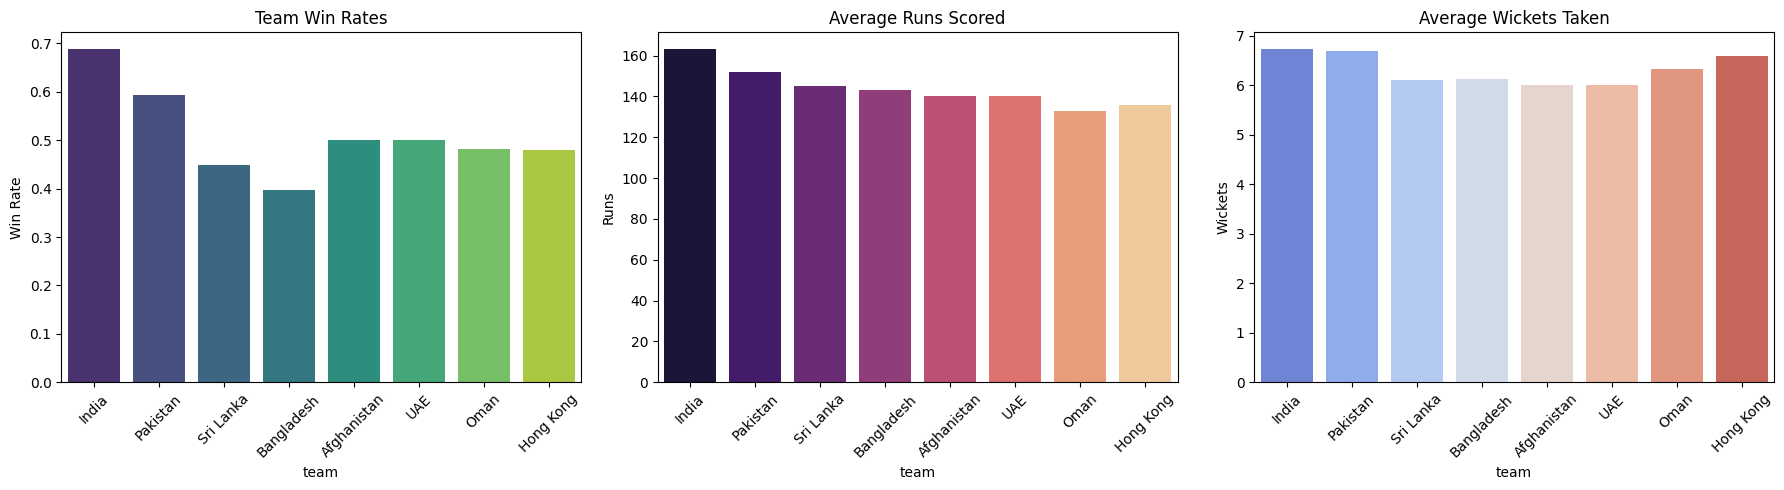

C:\Users\K\AppData\Local\Temp\ipykernel_23340\4174228122.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Team", y="Points", data=df_points, palette="crest")


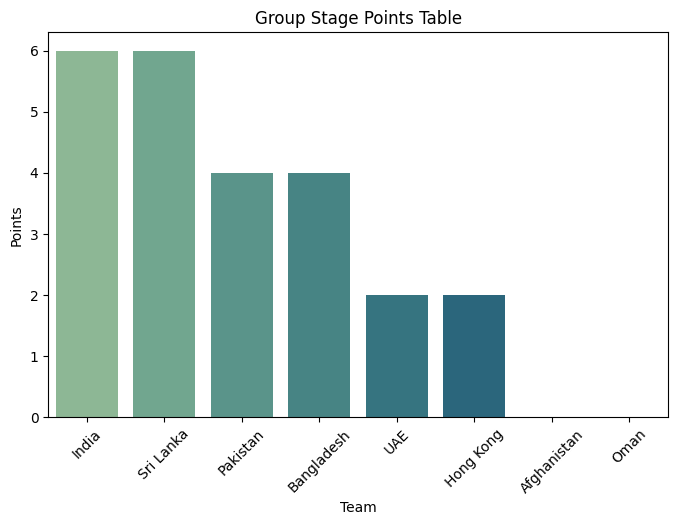

C:\Users\K\AppData\Local\Temp\ipykernel_23340\4174228122.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Team", y="Points", data=df_points, palette="crest")


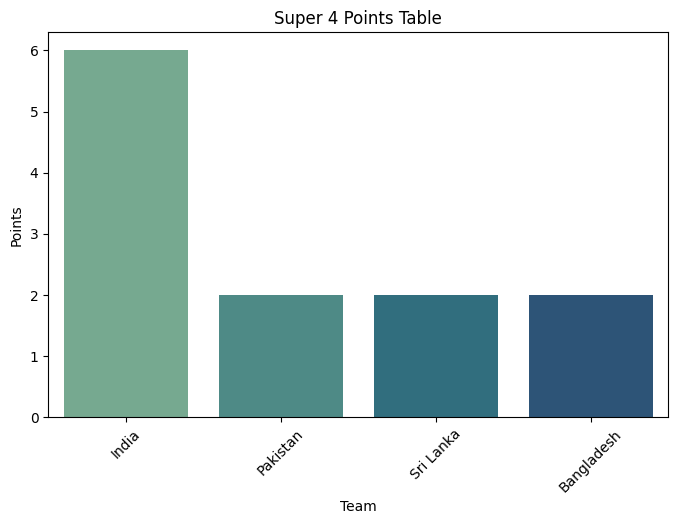

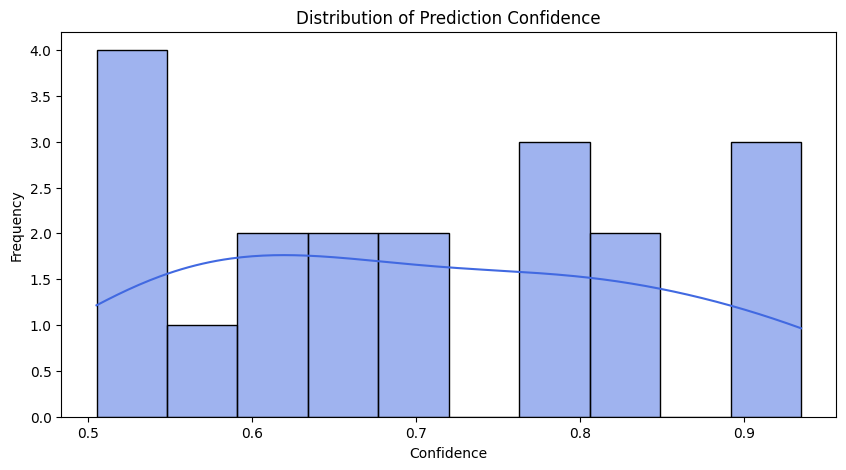

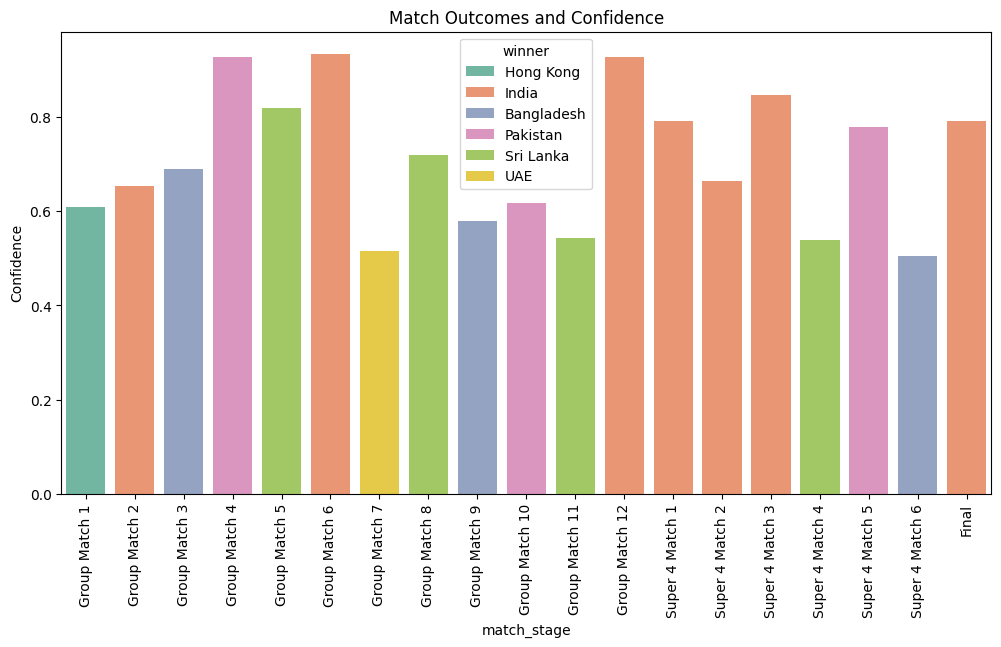

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# =========================
# 📊 TEAM STATS VISUALIZATION
# =========================
def plot_team_stats(team_stats):
    df_stats = pd.DataFrame(team_stats).T.reset_index().rename(columns={'index': 'team'})
    
    fig, axes = plt.subplots(1, 3, figsize=(18,5))
    
    # Win Rate
    sns.barplot(x="team", y="win_rate", data=df_stats, ax=axes[0], palette="viridis")
    axes[0].set_title("Team Win Rates")
    axes[0].set_ylabel("Win Rate")
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
    
    # Avg Runs
    sns.barplot(x="team", y="avg_runs_scored", data=df_stats, ax=axes[1], palette="magma")
    axes[1].set_title("Average Runs Scored")
    axes[1].set_ylabel("Runs")
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
    
    # Avg Wickets Taken
    sns.barplot(x="team", y="avg_wickets_taken", data=df_stats, ax=axes[2], palette="coolwarm")
    axes[2].set_title("Average Wickets Taken")
    axes[2].set_ylabel("Wickets")
    axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45)
    
    plt.tight_layout()
    plt.show()


# =========================
# 📊 TOURNAMENT VISUALIZATION
# =========================
def plot_points_table(points, stage="Group Stage"):
    df_points = pd.DataFrame(list(points.items()), columns=["Team", "Points"]).sort_values("Points", ascending=False)
    
    plt.figure(figsize=(8,5))
    sns.barplot(x="Team", y="Points", data=df_points, palette="crest")
    plt.title(f"{stage} Points Table")
    plt.xticks(rotation=45)
    plt.ylabel("Points")
    plt.show()


def plot_prediction_confidence(df_all):
    plt.figure(figsize=(10,5))
    sns.histplot(df_all["prediction_confidence"], bins=10, kde=True, color="royalblue")
    plt.title("Distribution of Prediction Confidence")
    plt.xlabel("Confidence")
    plt.ylabel("Frequency")
    plt.show()


def plot_match_outcomes(df_all):
    plt.figure(figsize=(12,6))
    sns.barplot(x="match_stage", y="prediction_confidence", hue="winner", data=df_all, dodge=False, palette="Set2")
    plt.title("Match Outcomes and Confidence")
    plt.xticks(rotation=90)
    plt.ylabel("Confidence")
    plt.show()


# =========================
# CALL VISUALIZATION FUNCTIONS
# =========================
plot_team_stats(team_stats)
plot_points_table(teams_points, "Group Stage")
plot_points_table(super4_points, "Super 4")
plot_prediction_confidence(df_all)
plot_match_outcomes(df_all)


C:\Users\K\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128203 (\N{CLIPBOARD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


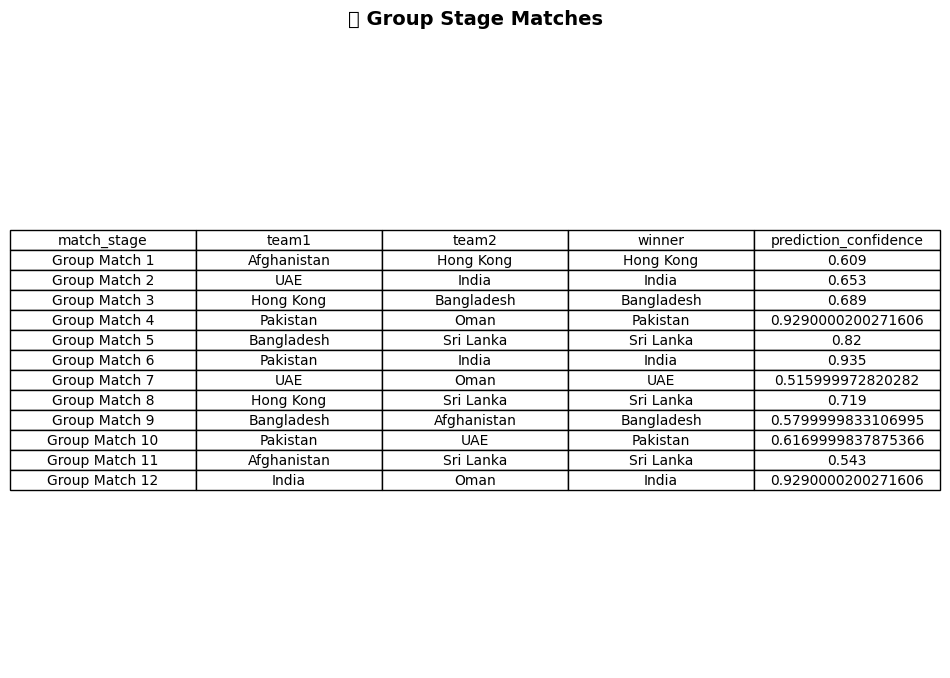

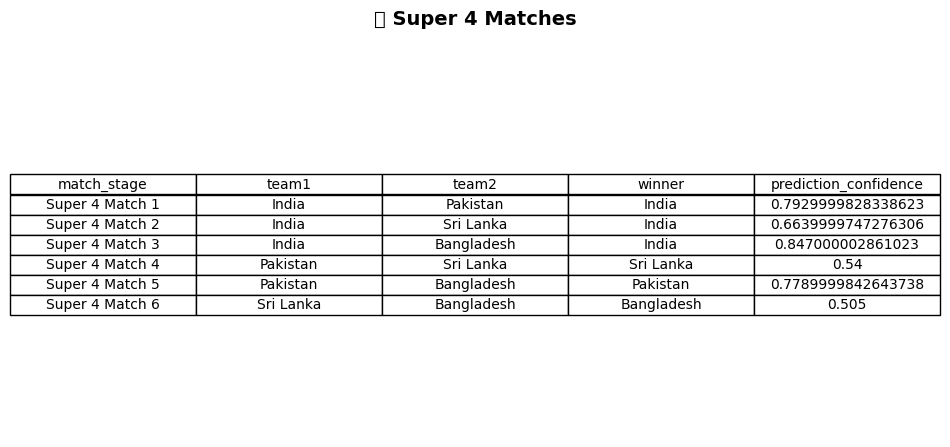

C:\Users\K\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 127942 (\N{TROPHY}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


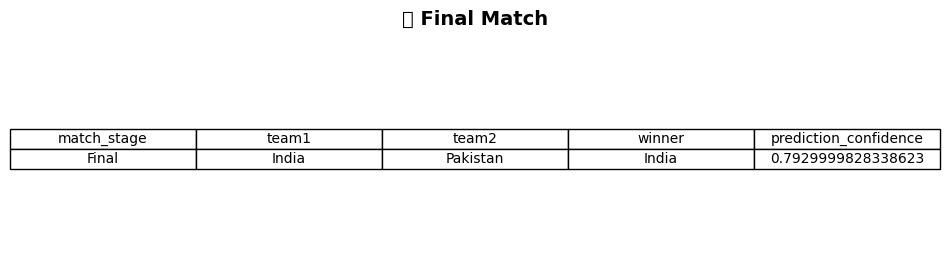

In [5]:
import matplotlib.pyplot as plt

# =========================
# 📋 TABLE VISUALIZATION
# =========================
def plot_match_table(df, title="Match Results"):
    fig, ax = plt.subplots(figsize=(10, len(df)*0.5 + 2))
    ax.axis("tight")
    ax.axis("off")
    
    # Create table from DataFrame
    table = ax.table(
        cellText=df.values,
        colLabels=df.columns,
        cellLoc="center",
        loc="center"
    )
    
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)
    
    ax.set_title(title, fontweight="bold", fontsize=14, pad=20)
    plt.show()


# =========================
# 📊 CALLING FOR YOUR STAGES
# =========================
# Group Stage
plot_match_table(df, "📋 Group Stage Matches")

# Super 4
plot_match_table(df_super4, "📋 Super 4 Matches")

# Final
plot_match_table(df_final, "🏆 Final Match")


In [9]:
# Save group stage results
df.to_csv("group_stage_predictions.csv", index=False)

# Save Super 4 results
df_super4.to_csv("super4_predictions.csv", index=False)

# Save Final result
df_final.to_csv("final_predictions.csv", index=False)
